UNet using  Oxford-IIIT pet dataset, available as part of the TensorFlow Datasets (TFDS)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import Sequential,layers , utils
import tensorflow_datasets as tfds
import os

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJN2JJQ/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJN2JJQ/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path=PosixGPath('/tmp/tmpfdsmeltjtfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        

Data Preperation

In [4]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

   return input_image, input_mask


def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [5]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

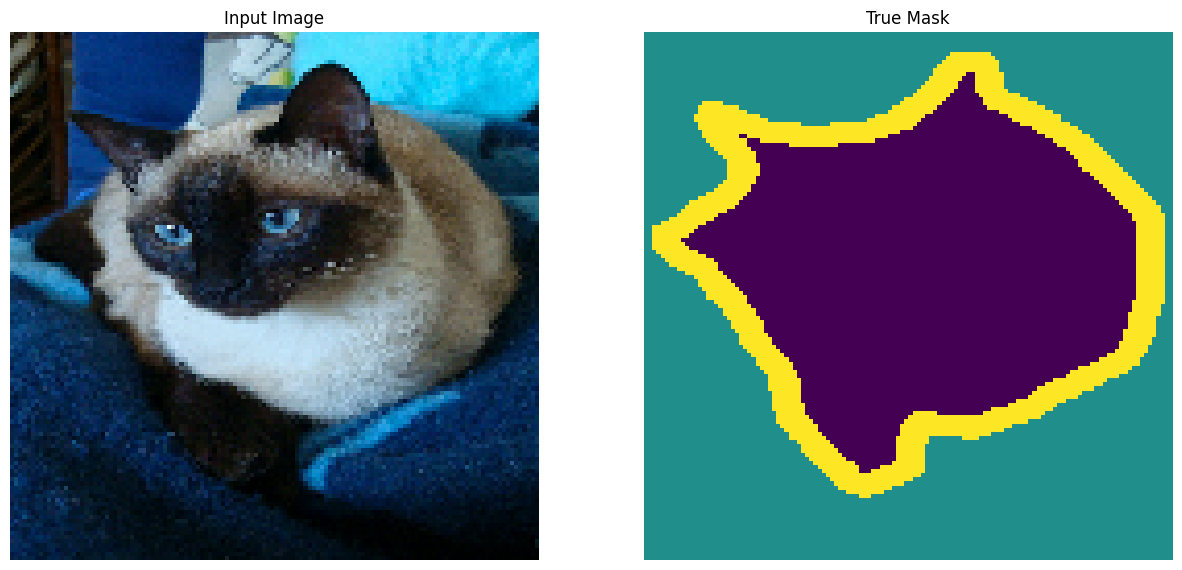

In [6]:
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

Unet Model

![Unet Architecture](Unet_Architecture.PNG)


In [7]:
# This function contains Conv2d-Relu-Conv2d-Relu
def double_conv_block(x , n_filters):
    x = layers.Conv2D( n_filters , 3  , padding = "same", activation = 'relu' , kernel_initializer = 'he_normal')(x)
    x = layers.Conv2D( n_filters , 3  , padding = "same", activation = 'relu' , kernel_initializer = 'he_normal')(x)

    return x

# This function for downsampling or feature extraction to be used in the encoder.
def downsample_block( x  , n_filters):
    f = double_conv_block(x , n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f , p

# This function is for upsampling for the decoder
def upsample_block(x , conv_feature , n_filters ):
    x = layers.Conv2DTranspose( n_filters, 3 , 2 ,  padding = 'same')(x)
    x = layers.concatenate([x , conv_feature])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x , n_filters)

    return x

In [8]:
def build_unet_model():
     # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model


unet_model = build_unet_model()

In [9]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

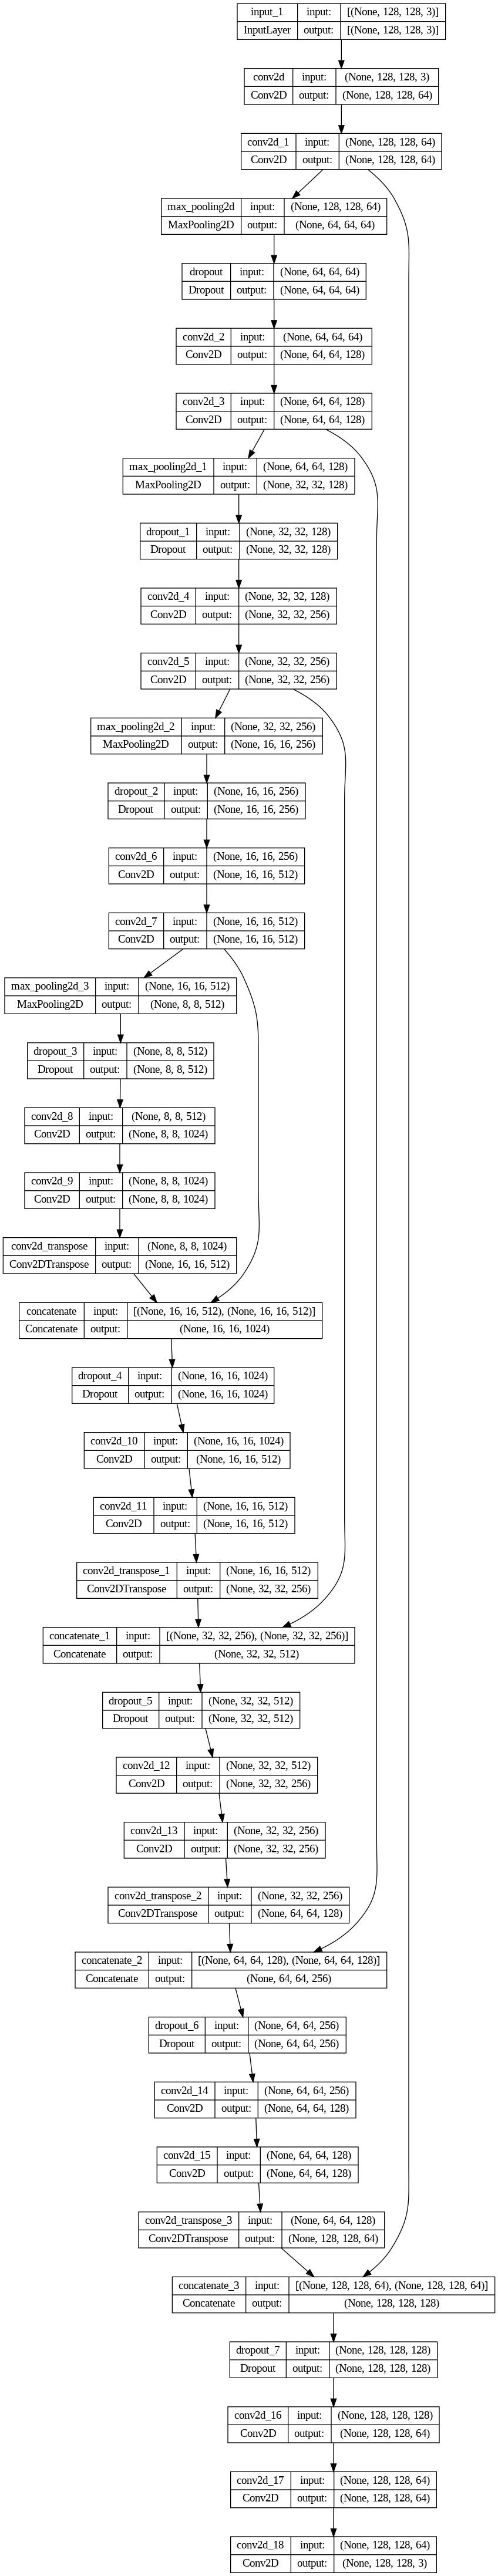

In [10]:
utils.plot_model(unet_model , show_shapes = True)

Training

In [11]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [12]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20
57/57 [==============================] - 67s 194ms/step - loss: 0.8762 - accuracy: 0.5945 - val_loss: 0.8235 - val_accuracy: 0.6082
Epoch 2/20
57/57 [==============================] - 24s 150ms/step - loss: 0.7777 - accuracy: 0.6513 - val_loss: 0.6635 - val_accuracy: 0.7343
Epoch 3/20
57/57 [==============================] - 9s 150ms/step - loss: 0.6274 - accuracy: 0.7462 - val_loss: 0.6003 - val_accuracy: 0.7533
Epoch 4/20
57/57 [==============================] - 9s 153ms/step - loss: 0.5758 - accuracy: 0.7707 - val_loss: 0.5308 - val_accuracy: 0.7909
Epoch 5/20
57/57 [==============================] - 8s 150ms/step - loss: 0.5191 - accuracy: 0.7954 - val_loss: 0.4797 - val_accuracy: 0.8119
Epoch 6/20
57/57 [==============================] - 9s 151ms/step - loss: 0.4762 - accuracy: 0.8140 - val_loss: 0.4683 - val_accuracy: 0.8123
Epoch 7/20
57/57 [==============================] - 9s 150ms/step - loss: 0.4428 - accuracy: 0.8277 - val_loss: 0.4438 - val_accuracy: 0.8316
Epoc

In [13]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Save the weights of the model to Google Drive
unet_model.save_weights('/content/drive/MyDrive/My_Projects/unet_model_weights.h5')


Mounted at /content/drive


<function matplotlib.pyplot.show(close=None, block=None)>

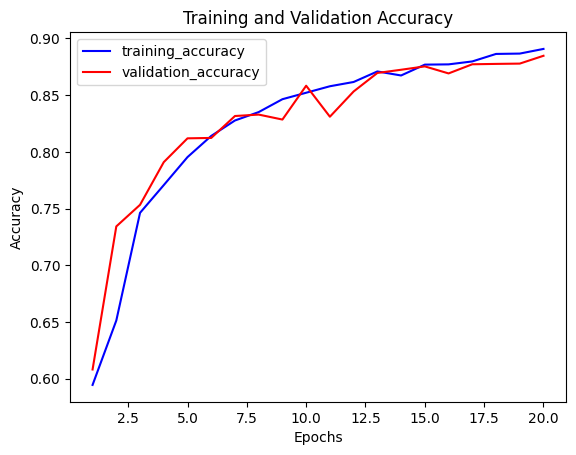

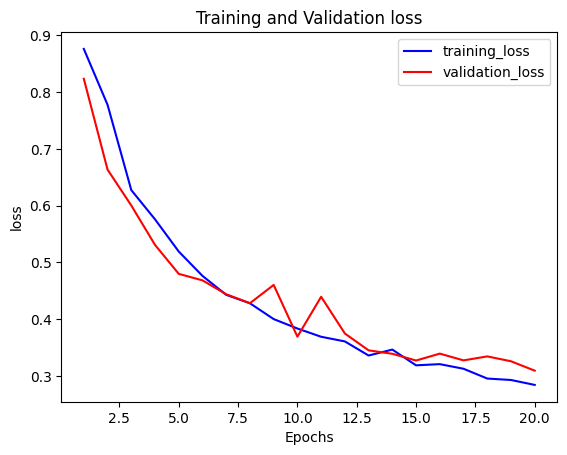

In [14]:
import matplotlib.pyplot as plt

train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(1 , NUM_EPOCHS+1)

plt.figure()
plt.plot(epochs , train_acc , 'b' , label = 'training_accuracy')
plt.plot(epochs , val_acc , 'r' , label = 'validation_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show

plt.figure()
plt.plot(epochs , train_loss , 'b' , label = 'training_loss')
plt.plot(epochs , val_loss , 'r' , label = 'validation_loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show

In [15]:
test_loss, test_accuracy = unet_model.evaluate(test_batches)

11/11 [==============================] - 2s 38ms/step - loss: 0.3091 - accuracy: 0.8847


1/1 [==============================] - 0s 37ms/step


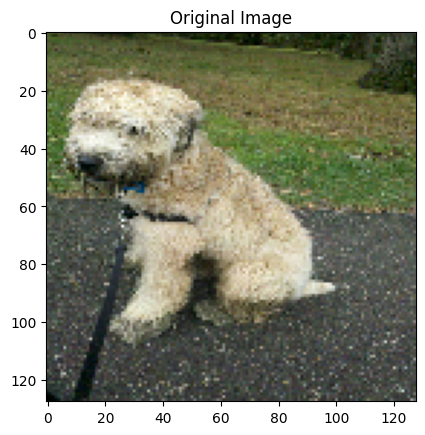

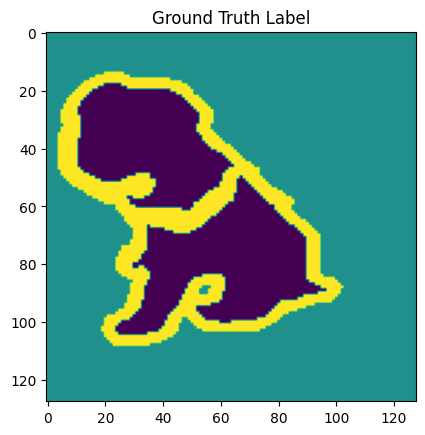

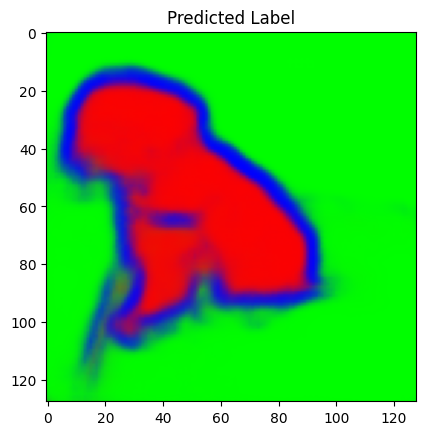

In [41]:
import matplotlib.pyplot as plt

sample_index = 1  # index starts from 0
batch_number = 2

test_iterator = iter(test_batches)
for _ in range(sample_index + 1):
    image_batch, label_batch = next(test_iterator)
image = image_batch[batch_number]
label = label_batch[batch_number]

# Make predictions using the trained model
predicted_label = unet_model.predict(image[None, ...])[0]

# Display the original image
plt.imshow(image)
plt.title('Original Image')
plt.show()

# Display the ground truth label
plt.imshow(label)
plt.title('Ground Truth Label')
plt.show()

# Display the predicted label
plt.imshow(predicted_label)
plt.title('Predicted Label')
plt.show()
